# 1. Introduction

In the heatwave risk literature the social vulnerability index is commonly referred to as the **Heat Vulnerability Index (HVI)**, highlighting its specific application to assessing risks associated with heatwaves. There are two of the most widely used methods of the HVI construction - the **principal component analysis (PCA)** and **normalized variable equal weight aggregation (additive approach)** (Bao t. al., 2015; Niu et. al., 2021). 

Both index variations are commonly used for risk mapping with a goal to identify risk prone areas for further suggestions on the prevention and adaptation measures(Bao t. al., 2015; Niu et. al., 2021). **This index calculation guide offers to apply each method to a case study - heatwave socio-economic vulnerability dynamics in Latvia -  to compare their applicability to climate risk assessment in both academic and non academic  fields**.

PCA is often conducted with reference to the predominantly used in risk studies Social Vulnerability Index (SoVI) to environmental hazards introduced by Cutter, Boruff, and Shirley (2003). When adapting this method for analyzing heatwave risks, researchers select variables specifically related to heatwave scenarios and apply PCA to identify a new reduced set of variables representing underlying patterns in the data, that later are used for the index construction (Bao t. al., 2015; Niu et. al., 2021). 

The more straithgforward additive approach is used less commonly than PCA, but is still valued by researchers for its simplicity in calculation and clarity in interpreting of the results (Bao t. al., 2015). Like for a PCA based index, vulnerabiltiy variables are selected based on their relation to heatwave risks (Bao t. al., 2015; Niu et. al., 2021). 

Conceptually, quantification of both indexes in this guide is based on Cutter, Boruff and Shirley (2003) adaptation of the **Hazards-of-Place Model of Vulnerability** (Figure 1).

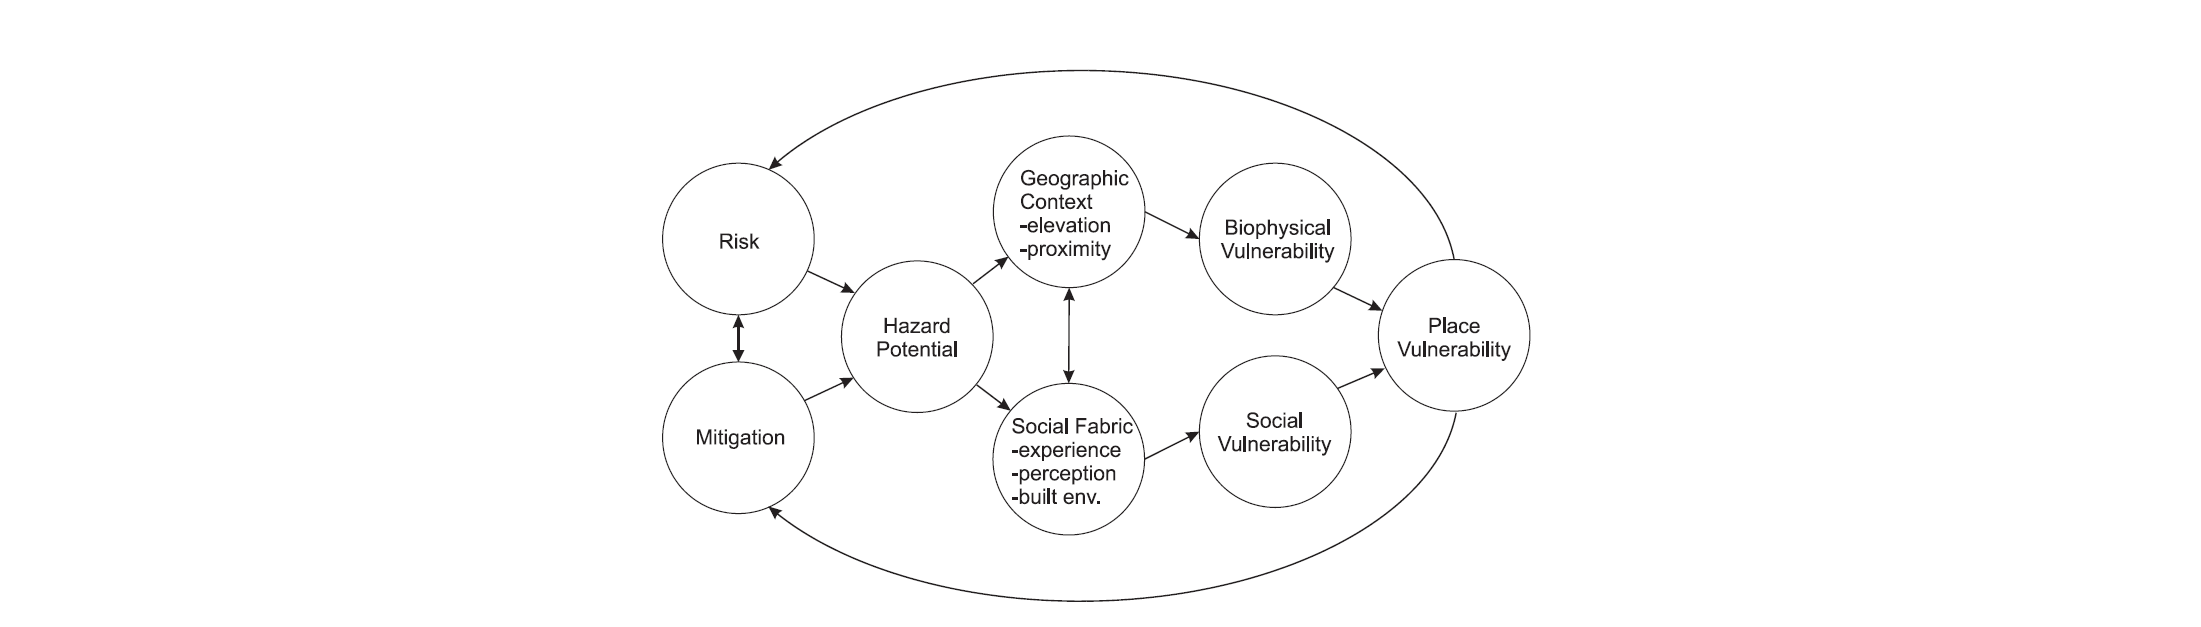

**Figure 1.** *The Hazards-of-Place Model of Vulnerability (Cutter, Boruff & Shirley, 2003; modified from Cutter, 1996).*

In this conceptual framework *risk* is defined as an objective evaluation of a hazard event's likelihood. It interacts with *mitigation*
efforts to reduce risks or their impacts. Risk and mitigation interaction results in *hazard potential*. This potential is either
moderated or intensified by a *geographic context* and *social fabric*. Geogrpahic context is defined as a location and proximity by the authors. The **social fabric** involves the community's experience with hazards and its
ability to react, manage, recover, and adapt to a hazard. Social fabric is influenced by demographic,
economic, and housing characteristics. The overall *vulnerability of a place* is determined by the interaction of
*social and biophysical vulnerabilities*.

This vulnerability index analysis specifically focuses on the social vulnerability and social fabric aspect of the model. The aim is to assess vulnerability dynamics in Latvia and consequent vulnerability index performance. de Rutier and van Loon (2022) identify key types of vulnerability dynamic, one of which is underlying dynamics. This type includes factors such as conflict, migration, and economic recession, influenced by changes in regional population, economic characteristics, immigration, displacement, poverty, and political instability. This case study seeks to analyze underlying temporal and spatial dynamics of social vulnerability to heatwaves in Latvia, and show its potential to application of the same analysis in other EU states. 

# 2. Guide Structure

This is Part 1 of the Calculation Guide that focuses on the index construction and interpetation of the index results. 
The Part 2 of the Guide focuses on the application of the index to heatwave risk assessment.

Main steps in index calculation part:
1. Introduction.
2. Guide structure.
3. Setting up the code.
4. Making and plotting Local Administrative Units Map for further visual presentation of vulnerability variables and vulnerability index.
5. Inspecting vulnerability variables that will be used for index construction.
6. Calcualting Heatwave Vulnerability Index using SoVI approach.
7. Calcualting Heatwave Vulnerability Index using additive approach.
8. Validating indexes using crude death rate.
9. Interpreting and comparing index results.

# 3. Code Setup

**Run this code to install and import all the necessary packages.**

In [ ]:
# Package for downloading data and managing files
import os

# Packages for handling geospatial maps and data
import geopandas as gpd
import rasterio
import rioxarray
from rasterstats import zonal_stats
from rasterio.enums import Resampling

# Packages for working with numerical data and tables
import pandas as pd
import numpy as np

# Packages for plotting maps
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

#Packages for working with PCA analysis
!pip install factor-analyzer

#Packages for statisticl analysis
! pip install statsmodels

# 4. Local Administrative Units (LAU) map

**[ LAU EUROSTAT map](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units) is outdated for Latvia. Therefore I used a map of current [Latvian administrative territories](https://data.gov.lv/dati/eng/dataset/administrativo-teritoriju-karte/resource/85aab9e3-a65a-42c0-ab8f-be249f96c58d?inner_span=True) from Latvia's dataset to compose the LAU for the year 2022.**

**This map will be used futher to display social vulnerability variables and social vulnerability indices. Run the code to see the map.**

In [ ]:
# Relative paths from the notebook's directory
municipalities_path = os.path.join("input files", "Administrative territories", "novadi", "Novadi.shp")
cities_path = os.path.join("input files", "Administrative territories", "pilsetas", "Pilsetas.shp")

# Checking if the paths exist
for path in [municipalities_path, cities_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The required file does not exist: {path}")

# Checking if an output directory exists, and if not, creating it
output_dir = os.path.join("output")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print("Output directory created.")
else:
    print("Output directory already exists.")

# Opening Latvia's regions map
municipalities = gpd.read_file(municipalities_path)
cities = gpd.read_file(cities_path)

#Creating LAU 2022 dataset based on the data described in the link above
cities_LAU = ["Rīga", "Daugavpils", "Jelgava", "Jūrmala", "Liepāja", "Rēzekne", "Ventspils"]
cities_LAU_2022 = cities[cities['LABEL'].isin(cities_LAU)]

#THE MAP
#Combining LAU cities and LAU municipalities to have one map
LV_LAU_2022 = pd.concat([cities_LAU_2022, municipalities], ignore_index=True)

#THIS PART PLOTS THE MAP
fig, ax = plt.subplots(figsize=(5, 5))
LV_LAU_2022.plot(ax=ax, facecolor='green', edgecolor='k', linewidth=0.5)
ax.set_title('Latvia LAU 2022')
ax.set_xlabel('X coordinate in the projection'); ax.set_ylabel('Y coordinate in the projection')

plt.show()

# #displays the dataframe
# # display(LV_LAU_2022.head())

# 5. Vulnerability Variables

## 5.1. Variable Inspection

**Run this code to import vulnerability variables' dataset.**

In [ ]:
# Relative path from the notebook's directory
variables_path = os.path.join("input files", "social vulnerability variables.csv")

# Checking if the new dataset path exists
if not os.path.exists(variables_path):
    raise FileNotFoundError(f"The required file does not exist: {variables_path}")

# Reading the new dataset into a pandas DataFrame
variables_df = pd.read_csv(variables_path)

# Creates a list of unique values from the 'variable' column
unique_variables = variables_df['variable'].unique()

# A dictionary to hold dataframes for each variable
variables_dfs = {}
for variable in unique_variables:
    variables_dfs[variable] = variables_df[variables_df['variable'] == variable]

# Dictionary to hold the merged vulnerability and LAU geodataframes
variables_gdfs = {}
for variable, variable_df in variables_dfs.items():
    variable_gdf = LV_LAU_2022.merge(variable_df, left_on='LABEL', right_on='LAU 2022', how='left')
    variables_gdfs[variable] = variable_gdf

# A list to store the year column names
years = []
for col in variables_df.columns:
    if col.isnumeric():
        years.append(col)

**Vulnerability Variables**

Impact assessment based on previous research on heatwave and climate risk in Latvia was used to
extract variables indicating socio-economic vulnerability of a population, such as
elderly percentage of total population in a LAU, roma people percentage of total population in a LAU or unemployed percentage of total population in a LAU from Latvian 2000, 2011 and 2021 census datasets. The dataset
(table 1) consists of the open data gathered from the [Central Statistical Bureau of Latvia](https://stat.gov.lv/lv).
Only consistent variables that were found in all three CENSUS datasets were used for variable
selection and data set construction for comparability reasons. For more details of variable selection please see attached text version of the guide.
**<span style="color:red;">[ATTACH LINK!]** </span>

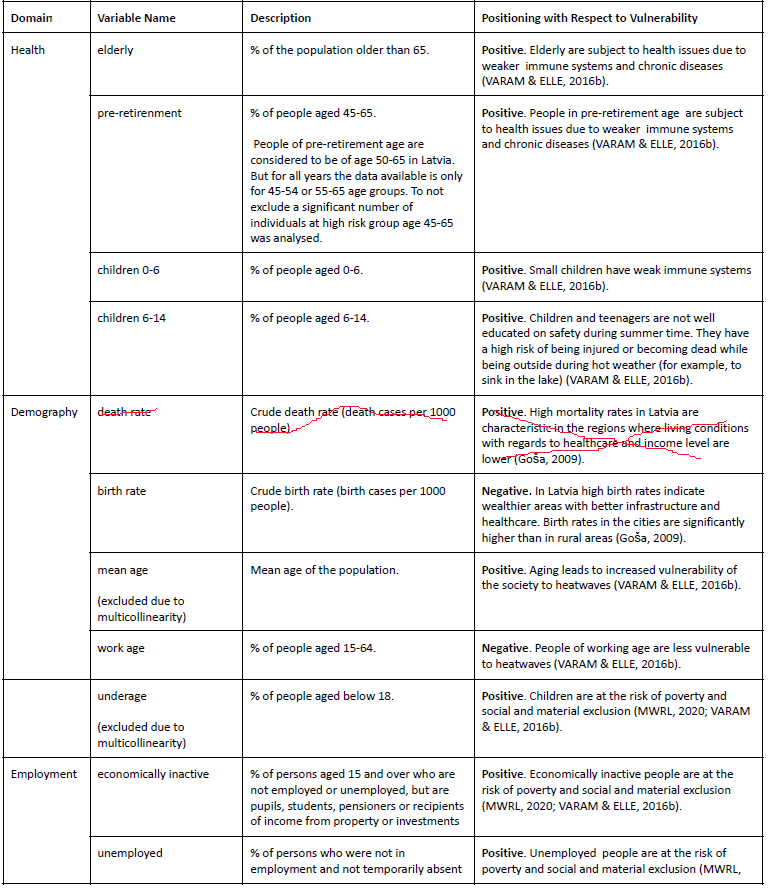
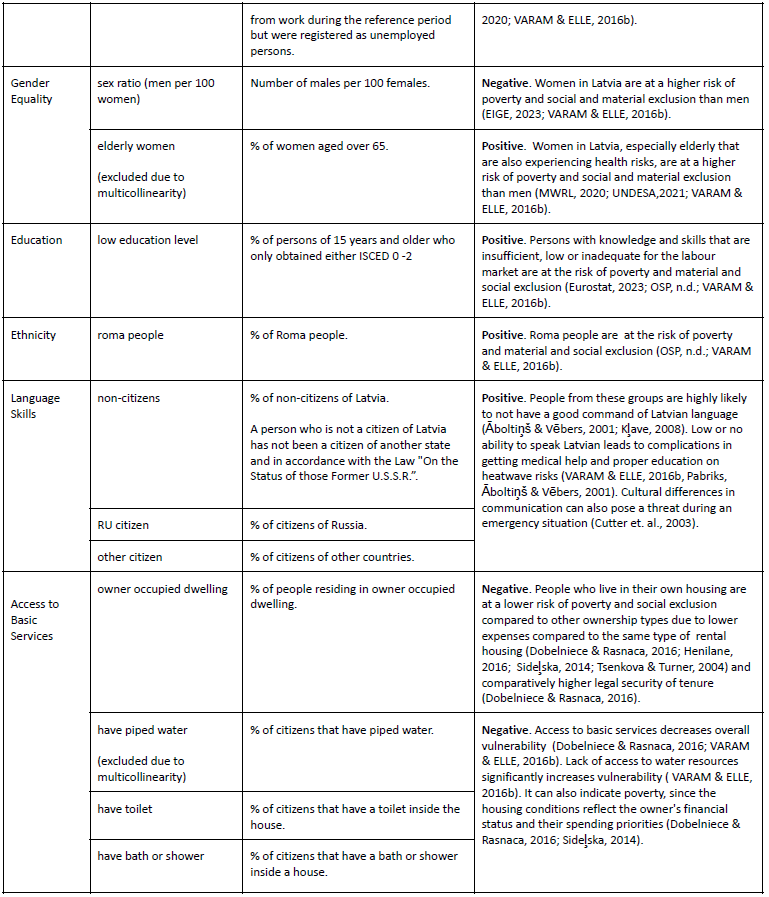

**<span style="color:red;">[I WILL ADD THE NEW UPDATED AND PRETTY TABLE AFTER I FINISH THE TEXT VERSION OF THE GUIDE]** </span>

**Run the code to plot spatial distribuiton of each variable for each year. The code takes some time to run, it can take up to 5 minutes.**

**Each year's each variable's legend has its own min and max value.
The value units can be found in the table above.**

In [ ]:
#Making a plot

from matplotlib.colors import Normalize #By using Normalize, the color representation for each subplot is made consistent.
                                        #For example, a particular shade of red represents the same value range across all subplots,
                                        #regardless of the actual minimum and maximum data values in each subplot. 
                                        #This makes it easier to visually compare different plots without getting misled by varying color scales.
num_columns = len(years)
num_rows = len(variables_gdfs)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows), squeeze=False)

for row_idx, (variable, variable_gdf) in enumerate(variables_gdfs.items()): #Making sure each plot has its own min and max value on the lengend
    for col_idx, year in enumerate(years):
        ax = axes[row_idx, col_idx]  
        vmin = variable_gdf[year].min()  # Minimum value for the colorbar
        vmax = variable_gdf[year].max()  # Maximum value for the colorbar

        variable_gdf.plot(
            column=year,
            ax=ax,
            legend=True,
            cmap='Reds',
            norm=Normalize(vmin=vmin, vmax=vmax),  #Normalizes data to the [0, 1] interval before it's mapped to colors using a colormap
            legend_kwds={'orientation': "vertical", 'shrink': 0.5}  
        )
        
        ax.set_title(f"{variable} in {year}")
        ax.set_xlabel('X coordinate in the projection')
        ax.set_ylabel('Y coordinate in the projection')

plt.tight_layout() 
plt.show()

## 5.2. Preparation for Further Analysis

**Firstly, it is needed to pivot the tables to get the dataset for each year, where all variables for all locations are represented.**

This part of the code reformats the initial dataframe into dataframes holding variables for each year separately.

In [ ]:
years_list = [int(year) for year in years] #reformats strings from the inital column names into integers

dfs_by_year = {} #creates dictionary where all CENSUS dataframes will be located

#Pivoting the table and dispalying each df
for year in years_list:
    # Pivots the table: rows are 'LAU name', columns are 'variable', and the cells contain data for a 'year'
    df_pivot = variables_df.pivot(index='LAU 2022', columns='variable', values=str(year))
    dfs_by_year[year] = df_pivot
    
    # Displays the pivoted df
    print("")
    print(f"\nCENSUS dataset for the year {year}:")
    display(df_pivot.head())
    print("")

**Secondly, the data needs to be normalized. This part normalizes each year's dataset to z-scores.**
 
Within each time period (a year in this case) every variable is transformed to have a mean of zero and a standard deviation of one. This way different variables can be properly compared to each other within one year, and one variable can be compared to itself between different years.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initializes the scaler
scaler = StandardScaler()

normalized_dfs_by_year = {} # Dictionary to store normalized dataframes

#Normalizing each pivoted df
for year in years_list:
    normalized_df = pd.DataFrame(scaler.fit_transform(dfs_by_year[year]), 
                                 columns=dfs_by_year[year].columns, 
                                 index=dfs_by_year[year].index)
    normalized_dfs_by_year[year] = normalized_df
    
    # Displaying each normalized df
    print("")
    print(f"\nNormalized DataFrame for the year {year}:")
    display(normalized_df.head())


# 6. HVI (SoVI Approach)

SoVI provides a comparative metric for underlying social vulnerability factors on a subnational level (Cutter & Finch, 2008). SoVI uses PCA and rotation of the PCA principal components using factor analysis varimax rotation to find hidden patterns
in data, allowing them to measure and show vulnerability through census, economic, or environmental information (Cutter et. al. 2003, Cutter & Finch, 2008).

The original SoVI methodology did not include weighing of the variables to avoid introducing additional subjectivity, nevertheless many researchers chose to modify this approach by weighing the index based on expert opinions or PCA outcomes. In this study no weighing is applied in construction of the index to avoid extra uncertainty and provide a solid comparability with the index calculated based on additive approach.

The SoVi construction is performed according to the method described by Cutter et. al. (2003). A varimax rotated PCA is used for 21 variables to reduce dimensionality and get new variables containing most of the information on vulnerability in the country. The new
variables form the basis for the SoVI index calculation.

**SoVI calculation consists of 6 main steps**

1. Examining suitability for the PCA with Bartlett's test of sphericity and the Kaiser-Meyer-Olkin (KMO) measure.
2. Testing multicollinearity.
3. Performing PCA.
4. Selecting calculated principal components applying Keiser Criterion (eigenvalues > 1).
5. Examining component loading scores to identify the latent variables related to vulnerability and assigning cardinal direction to each factor according to its theoretical relationship to vulnerability.
6. Calculating factor vulnerability scores for each LAU.

Each step is explained in more detail in respective sections.

## 6.1. Examining suitability for the PCA with Bartlett's test of sphericity and the Kaiser-Meyer-Olkin (KMO) measure.

Bartlett’s Test of Sphericity: This test checks if the correlation matrix of the variables diverges significantly from an identity matrix, which would indicate that the variables are interrelated, and therefore suitable for PCA. It utilizes a chi-square distribution to determine if there is enough evidence to suggest that the variables are correlated.

Kaiser-Meyer-Olkin (KMO) Measure: This is a method for assessing the appropriateness of a correlation matrix for factor analysis, the KMO test measures the sampling adequacy for each variable and for the complete model. This measure ranges from 0 to 1, where values closer to 1 indicate that a higher proportion of variance is shared among all the analyzed variables, making factor analysis more appropriate. A KMO value of 0.5 or higher generally suggests that factor analysis may be useful. The results guide researchers in deciding whether the data is apt for PCA, ensuring the analysis is both meaningful and reliable.

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

for year, norm_df in normalized_dfs_by_year.items():

    print(f"\nYear: {year}")
    
    # Perform Bartlett's test of sphericity
    chi_square_value, p_value = calculate_bartlett_sphericity(norm_df)
    print("\nBartlett's test of sphericity:")
    print("Chi-square value:", chi_square_value)
    print("P-value:", p_value)
    if p_value < 0.05:
        print("Data is suitable for factor analysis according to Bartlett's test.")
    else:
        print("Data is not suitable for factor analysis according to Bartlett's test.")

    # Perform KMO test
    kmo_all, kmo = calculate_kmo(norm_df)
    print("\nKaiser-Meyer-Olkin (KMO) measure:", kmo)
    if kmo > 0.5:
        print("Data is suitable for factor analysis.")
    else:
        print("Data is not suitable for factor analysis.")


## 6.2. Testing Multicollinearity

In PCA multicollinearity among input variables can help in dimensionality reduction because it leads to a clearer pattern of variance explained by the principal components. Several original variables can be effectively summarized by fewer principal components due to their high correlation. Multicollinearity test can help predict PCA outcomes and explain the results later.

In [ ]:
#This part of the code plots corellation matrix heatmaps for each year and displays the correlation matrix table

for year, norm_df in normalized_dfs_by_year.items():
    correlation_matrix = norm_df.corr() #Performs normalization 

    #Creates a plot
    plt.figure(figsize=(10, 8)) 
    plt.matshow(correlation_matrix, fignum=1, cmap='coolwarm')  
    plt.title(f'Correlation Matrix for the year {year}', pad=20)
    plt.colorbar() 
    
    # Sets ticks and labels
    ticks = np.arange(len(correlation_matrix.columns))
    plt.xticks(ticks, correlation_matrix.columns, rotation=90)
    plt.yticks(ticks, correlation_matrix.columns)

    plt.grid(False)  #Turns off the grid to not obscure the cells
    plt.show() 
    
    display(correlation_matrix.head())

## 6.3. <span style="color:red;">[NEED HELP] </span> Performing PCA.

**The PCA analysis can be only perfomed in the R studio.**

<span style="color:red;"> ***I have tried to use scikit learn PCA and the rotator function from factor analyzer, but the results are terrible, it is impossible to interpret them. And there is no other option in Python to use PCA and then use varimax rotation on the Principal Compononets. Therefore I decided to use R psych package to perform PCA with rotation. But I failed to use R code sells in the same notebook. My kernel kept crashing. So I now use R markdown, which s located in the same folder*** </span> 

**Therefore, first it is needed to download the zet score dataframes into the directory as CSV files.**

In [ ]:
#Creates z_scores folder in the ouput folder
output_dir_for_z_scores = os.path.join("output","z_scores")
os.makedirs(output_dir_for_z_scores, exist_ok=True)
print(f"Output directory {'already exists' if os.path.exists(output_dir_for_z_scores) else 'created'}.")

In [ ]:
#Saves the normalized datasets into the folder
for year, norm_df in normalized_dfs_by_year.items():
    output_path = os.path.join(output_dir_for_z_scores, f"z_scores_{year}.csv")
    norm_df.to_csv(output_path, encoding='utf-8-sig')
    print(f"Saved normalized DataFrame for the year {year} to {output_path}")

**Perform the PCA analysis in R Studio. For that in the main folder open the script "PCA calculator for Heatwave SoVI" and follow the instructions there. After finishing, come back to this code and continue the analysis.**

__________________________________________________________ **RUN THE PCA CALCULATOR IN R**__________________________________________________________

**After running the R code in R studio a new folder have been created: output-> PCA.**

**There the datasets with:**
1. eigen values of rotated principal components;
2. variable loadings on rotated principle components;
3. proportion and cumulative proprtion of rotated components explained;
4. scores of rotated principal components have been saved.

**They will be used for further analysis in this notebook.**

**Please run the code to read the PCA results in.**

In [ ]:
# This part reads in eigenvalues files and creates a dictionary of eigenvalues dataframes
directory_path = os.path.join('output', 'PCA')

eigenvalues_dfs = {}

for filename in os.listdir(directory_path):
    if 'eigenvalues' in filename and filename.endswith('.csv'):
        parts = filename.split('_')
        year = parts[1] 
        year = int(year.split('.')[0])
        file_path = os.path.join(directory_path, filename)
        eigenvalues_dfs[year] = pd.read_csv(file_path)

# This part reads in variable loadings files and creates a dictionary of loadings dataframes
directory_path = os.path.join('output', 'PCA')

loadings_dfs = {}

for filename in os.listdir(directory_path):
    if 'loadings' in filename and filename.endswith('.csv'):
        parts = filename.split('_')
        year = parts[1] 
        year = int(year.split('.')[0])
        file_path = os.path.join(directory_path, filename)
        loadings_dfs[year] = pd.read_csv(file_path)

# This part reads in PCA scores files and creates a dictionary of PCA scores dataframes
directory_path = os.path.join('output', 'PCA')

PCA_scores_dfs = {}

for filename in os.listdir(directory_path):
    if 'PCA_scores' in filename and filename.endswith('.csv'):
        parts = filename.split('_')
        year = parts[2] 
        year = int(year.split('.')[0])
        file_path = os.path.join(directory_path, filename)
        PCA_scores_dfs[year] = pd.read_csv(file_path)


display(eigenvalues_dfs)       
display(loadings_dfs)
display(PCA_scores_dfs)

## 6.4. Selecting calculated principal components applying Keiser Criterion.

**At this step it is necessary to decide how many rotated principal components have to be used for index construction. For that a Keiser criterion will be used. Only rotated principal components with the eigen value higher then 1 will be used for index construction. For more details about Keiser criterion please refer to the text version of the guide.** **<span style="color:red;">[ATTACH LINK!]** </span>

In [ ]:
#This part of the code filters out the loadings dataset to extract components with eigen values > 1. 
# Dictionary to store the modified loadings DataFrames
modified_loadings_dfs = {}

#The loop to filter loadings dataset
for year, eigen_df in eigenvalues_dfs.items():
    # Identifies columns where the eigenvalue is greater than 1
    condition = eigen_df.iloc[:, 0] > 1
    filtered_index = eigen_df[condition].index
    significant_indices = filtered_index.tolist()

    if year in loadings_dfs:
        first_column_name = loadings_dfs[year].columns[0]
        columns_to_keep = [first_column_name]
        
        for index in significant_indices:
            column_name = loadings_dfs[year].columns[index + 1]
            columns_to_keep.append(column_name)
        
        modified_loadings_df = loadings_dfs[year][columns_to_keep]
        modified_loadings_dfs[year] = modified_loadings_df

# Display the modified DataFrames for inspection
for year, df in modified_loadings_dfs.items():
    print(f"Modified Loadings for {year}:")
    display(df)

In [ ]:
#This part of the code filters out the scores dataset to extract components with eigen values > 1.
# Dictionary to store the modified PCA scores DataFrames
modified_PCA_scores_dfs = {}

for year, eigen_df in eigenvalues_dfs.items():
    # Identifies columns where the eigenvalue is greater than 1
    condition = eigen_df.iloc[:, 0] > 1
    filtered_index = eigen_df[condition].index
    significant_indices = filtered_index.tolist()

    if year in PCA_scores_dfs:
        first_column_name = PCA_scores_dfs[year].columns[0]
        columns_to_keep = [first_column_name]
        
        for index in significant_indices:
            column_name = PCA_scores_dfs[year].columns[index + 1]
            columns_to_keep.append(column_name)
        
        modified_PCA_scores_df = PCA_scores_dfs[year][columns_to_keep]
        modified_PCA_scores_dfs[year] = modified_PCA_scores_df

# Display the modified dataframes for inspection
for year, df in modified_PCA_scores_dfs.items():
    print(f"Modified PCA scores for {year}:")
    display(df)

## 6.5. <span style="color:red;">[NEED SUGGESTIONS] </span> Assigning vulnerability directions. 

In the following section the theoretical directions regarding vulneraility will be assigned.

Only the variables with the loading which absolute value is higher than 0.5 will be considered as significant to use for direction assignment. A cardinal direction is assigned to each rotated component according to its theoretical relationship with vulnerability. Positive signs are attributed to factors that theoretically increase total vulnerability, while negative signs are assigned to those that theoretically reduced it. In instances where the relationship of a rotated component to vulnerability is unclear, the absolute value of the rotated component score is used.

The variable names that load high enough on the principal components have to be stored separateley to see later which vulnerability variables the index represents.

In [ ]:
#Filtering loadings with absolute value < 0.5

filtered_loadings_dfs = {}  #Dictionary to store dfs with filtered loadings
SoVI_structure_by_year = {} #Dictionary to store dfs with SoVI structure to use later for interpretation of the index structure
                            #After previous filtering some variables were excluded, therefore the structure of the index is changed

#The loop filters out low loadings
for year, modified_loadings_df in modified_loadings_dfs.items():
    numeric_columns = modified_loadings_df.columns[1:]
    variable_name_column = modified_loadings_df.columns[0]
    filtered_df = modified_loadings_df.copy()
    for index, row in filtered_df.iterrows():
        for column in numeric_columns:
            if abs(row[column]) < 0.5:
                filtered_df.at[index, column] = np.nan
 
    rows_with_values = filtered_df.dropna(how='all', subset=numeric_columns)[variable_name_column].tolist()
    SoVI_structure_by_year[year] = rows_with_values #saving variable that load high enough on the rotated componnets
    filtered_loadings_dfs[year] = filtered_df

    #Displaying filtered loadings and significant variables
    print(f"Filtered Loadings for {year}:")
    display(filtered_df)
    print(f"Rows with values for {year}: {rows_with_values}")


**Direction of each rotated component ("ABS", "+", "-") depends on the relationship of each variable to vulnerability. Each variables postioning with respect to vulnerability is described in the table in the "5. Vulnerability Variables" section.** 

**Variable loadings on the rotated components in 2000**
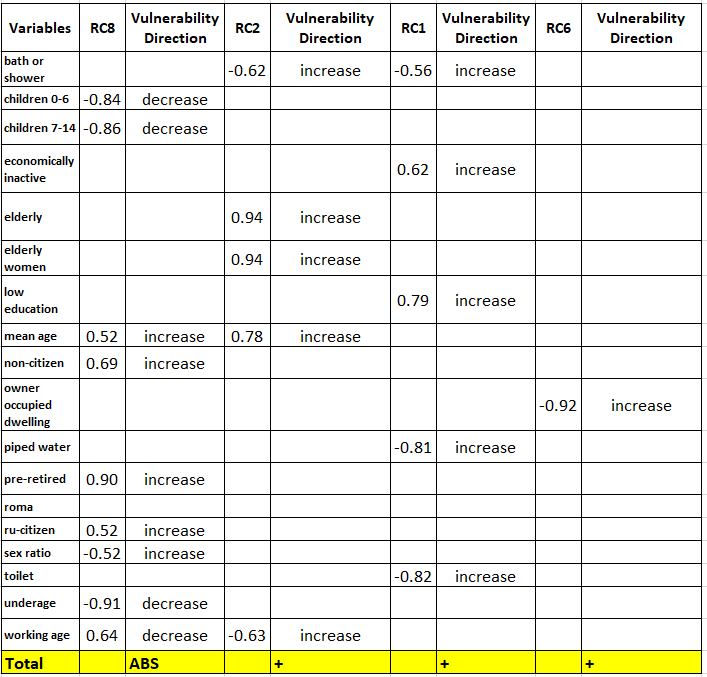

**Variable loadings on the rotated components in 2011**
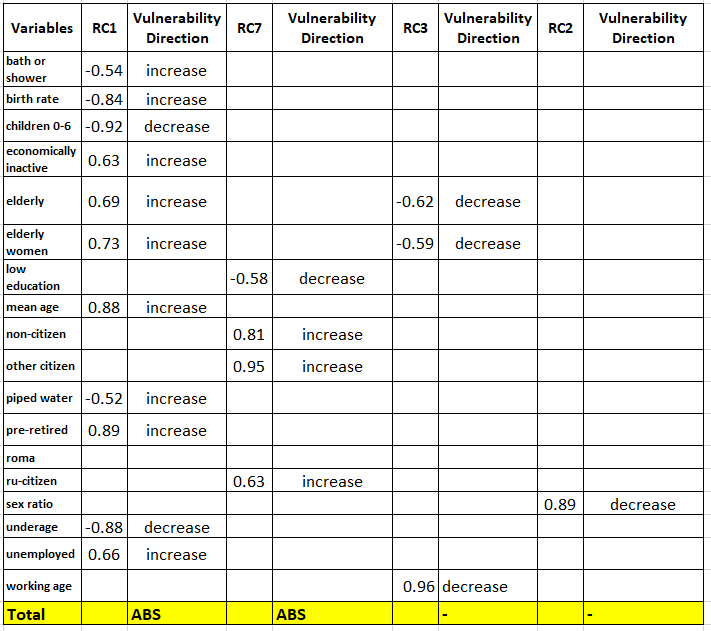

**Variable loadings on the rotated components in 2021**
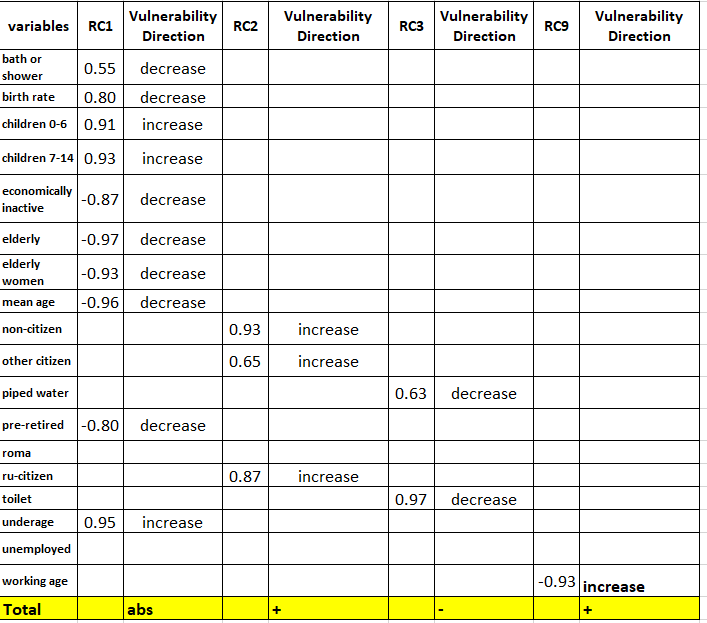

<span style="color:red;">[***I need some time to think how to make a code for assigning decrease/increase values automatically. I can do it myself for sure. I think I will just add a column in the initial varable file for the directions. And explain how to properly construct the dataset in the beginning. Or make something like I did for the Aggregated SoVI when I assigned -1 (decrease) and 1 (increase) here later in the code. And then claculate a consequent sign for a rotated component. I feel this way the user will pay more attention to the directions. But then it is longer to run. So I prefer the first version.***]  </span>


<span style="color:red;">[ **This part down here can be made automatic, without any manual addition of directions, if i add direction column to the initial variables dataset in the very beginning of the analysis and describe the directions in the section 5 in variable inspection and analysis preparation ,and in the text guide as well.**] </span>

In [ ]:
#Insert the the signs into operations according to the vulnerability direction for the rotated component from the yellow field
# "abs" = "abs"
# "None" = "+"
# "lambda x: -x" = "-"


operations = {
    2000: [abs, None, None, None], 
    2011: [abs, abs, lambda x: -x, lambda x: -x],
    2021: [abs, None, lambda x: -x, None]
}

## 6.6. Calculating SoVI values for each LAU.

**To calculate the final score it is needed to sum up scores of all rotated components for each location. The signs assigned above to each principle component for each year have to be used in this step.**

In [ ]:
#Calculating scores for each location

SoVI_scores_dfs = {} #storing scores' dataframes into a dictionary

# Initializes the normalization scaler
scaler = StandardScaler()

for year, ops in operations.items():
    SoVI_scores_df = modified_PCA_scores_dfs[year][[modified_PCA_scores_dfs[year].columns[0]]].copy() # Create the SoVI scores dataframe
    SoVI_scores_df["SoVI score"] = 0
    
    # Apply each operation for the rotated component to the corresponding component and update SoVI score
    for index, op in enumerate(ops, start=1):
        component = modified_PCA_scores_dfs[year][modified_PCA_scores_dfs[year].columns[index]]
        if op:
            component = op(component)  # Apply "operations" from above to calculate score
        SoVI_scores_df["SoVI score"] += component
        
    SoVI_scores_df['Normalized SoVI score'] = scaler.fit_transform(SoVI_scores_df[['SoVI score']]) #normalizing to z scores with a mean zero and st.dev of 1
    SoVI_scores_dfs[year] = SoVI_scores_df
    
    # Display the dataframes
    print(f"SoVI scores for {year}:")
    display(SoVI_scores_df)


**The scores for each location are calcualted and standardized within a dataframe for each separate year.**

**The final part of the score calcualtion is creating a plot.**

In [ ]:
from matplotlib.colors import TwoSlopeNorm

sovi_gdfs = {}

# Merging the dataframes with the shapefile
for year, sovi_scores_df in SoVI_scores_dfs.items():
    year_gdf = LV_LAU_2022.merge(sovi_scores_df, left_on='LABEL', right_on='LAU 2022', how='left')
    sovi_gdfs[year] = year_gdf

num_years = len(sovi_gdfs)
fig, axes = plt.subplots(1, num_years, figsize=(5 * num_years, 5), squeeze=False)

for col_idx, (year, year_gdf) in enumerate(sovi_gdfs.items()):
    ax = axes[0, col_idx]
    column_name = "Normalized SoVI score"

    # Set the normalization to have a fixed range of -3 to 3
    vmin, vcenter, vmax = -3, 0, 3
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # Plot
    year_gdf.plot(
        column=column_name,
        ax=ax,
        legend=True,
        cmap='coolwarm',  # 'coolwarm' is ideal for diverging scales
        norm=norm,
        legend_kwds={'orientation': "vertical", 'shrink': 0.5}
    )
    ax.set_title(f"SoVI {year} [st.dev.]")
    ax.set_xlabel('X coordinate in the projection')
    ax.set_ylabel('Y coordinate in the projection')

plt.tight_layout()
plt.show()

# 7. HVI (Aggregattion/Additive Approach)

The additive approach method in index calualtion uses the same dataset of the normalized vulnerability variables as SoVI approach. The difference is in the calculation process. The normalized values are further aggregatted together, assuming equal weight of each variable. This way no variable is excluded from the final score. The values from these indicators are then normalized once more. This index ranges from 0 to 1, where a score of 1 indicates the highest level of vulnerability to heatwave.

HVI calculation consists of 2 main steps.

1. Assigning directions to the variables according to their positiong with respect to vulnerability. Each variables postioning with respect to vulnerability is described in the table in the "5. Vulnerability Variables" section.
2. Calculating the HVI values and creating a plot.

## 7.1. Assigning vulnerability directions

**<span style="color:red;">This part can also be automated better if i add directions of vulnerability in the intial dataset**</span>

In [ ]:
#Printing the list of the unique variable names to assign direction to each in the next code snippet
print(unique_variables)

In [ ]:
# Assigns directions of the variables. Those that decrease vulnerability are set to be equal to -1
transformations = {
    'elderly': 1,
    'pre-retired': 1,
    'underage': 1,
    'children 0-6': 1,
    'children 7-14': 1,
    'birth rate': -1,
    'mean age': 1,
    'working age': 1,
    'economically inactive': 1,
    'unemployed': 1,
    'sex ratio': -1,
    'elderly women': 1,
    'low education': 1,
    'roma': 1,
    'non-citizen': 1,
    'ru-citizen': 1,
    'other citizen': 1,
    'owner occupied dwelling': -1,
    'toilet': -1,
    'bath or shower': -1,
    'piped water': -1
}

# Transforms normalized dataframes according to the vulnerability direction of the variables.
# Variables that decrease vulnerability have to be reversed. This is done by substracting their z score values from 1.
transformed_dfs_by_year = {}

for year, norm_df in normalized_dfs_by_year.items():
    transformed_df = norm_df.copy()
    for column, direction in transformations.items():
        if column in transformed_df.columns:
            if direction == -1:
                transformed_df[column] = 1 - transformed_df[column]
    transformed_dfs_by_year[year] = transformed_df
    display(transformed_df)


## 7.2. Index scores calculation

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Dictionary to store results
aggregated_hvi_dfs = {}

for year, df in transformed_dfs_by_year.items():
    if 'LAU 2022' in df.columns:
        df.set_index('LAU 2022', inplace=True)
    df['HVI AA score'] = df.sum(axis=1)
    df['Normalized HVI AA score'] = scaler.fit_transform(df[['HVI AA score']].values)
    result_df = df[['HVI AA score', 'Normalized HVI AA score']].copy()
    aggregated_hvi_dfs[year] = result_df


    print(f"HVI scores for {year}:")
    display(aggregated_hvi_dfs[year])


In [ ]:
#Plot the index values
from matplotlib.colors import TwoSlopeNorm

hvi_gdfs = {}

for year, hvi_scores_df in aggregated_hvi_dfs.items():
    year_gdf = LV_LAU_2022.merge(hvi_scores_df, left_on='LABEL', right_index=True, how='left')
    hvi_gdfs[year] = year_gdf

num_years = len(hvi_gdfs)
fig, axes = plt.subplots(1, num_years, figsize=(5 * num_years, 5), squeeze=False)

for col_idx, (year, year_gdf) in enumerate(hvi_gdfs.items()):
    ax = axes[0, col_idx]
    column_name = "Normalized HVI AA score"  

    # Setting the normalization to have a fixed range of -3 to 3 for standard deviation
    vmin, vcenter, vmax = -3, 0, 3
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # Plot
    year_gdf.plot(
        column=column_name,
        ax=ax,
        legend=True,
        cmap='coolwarm', 
        norm=norm,
        legend_kwds={'orientation': "vertical", 'shrink': 0.5}
    )
    ax.set_title(f"Aggregated HVI {year} [st.dev.]")
    ax.set_xlabel('X coordinate in the projection')
    ax.set_ylabel('Y coordinate in the projection')

plt.tight_layout()
plt.show()


# 8. <span style="color:red;">[STILL IN PROGRESS] </span> Index Validation Example 

Vulnerability index for heatwave hazard is most often validated against daily death cases counts during heatwaves. Unfortunately, currently there is no access to this data on LAU level in Latvia. However, there are records of annual crude death rate. Considering variable selection process, the index is assumed to be sensitive to annual crude death rate as well. For this example analysis annual crude death rate will be used. 

In [ ]:
#Uploading crude deathrate data for validation analysis
death_rate_path = os.path.join("input files", "crude death rate.csv")

if not os.path.exists(death_rate_path):
    raise FileNotFoundError(f"The required file does not exist: {death_rate_path}")

death_rate_df = pd.read_csv(death_rate_path)
death_rate_by_year = {}
scaler = StandardScaler()

# Creating separate dataframes for each year and normalizing the death rate
for year in years_list:
    df_pivot = death_rate_df.pivot(index='LAU 2022', columns='variable', values=str(year))
    if 'death rate' in df_pivot.columns:
        df_pivot['Normalized death rate'] = scaler.fit_transform(df_pivot[['death rate']])
    death_rate_by_year[year] = df_pivot

    print(f"Death rate dataset for the year {year}:")
    display(df_pivot)

## 8.1. SoVI HVI

**SoVI cannot be directly compared between years due to changing structure of the index components. Regression analysis can be performed only for each year separately.**

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

for year in SoVI_scores_dfs:
    # Merge the dataframes
    merged_df = SoVI_scores_dfs[year].merge(death_rate_by_year[year], on='LAU 2022')
    
    # Scatter plot with labels
    plt.figure(figsize=(12, 8)) 
    plt.scatter(merged_df['Normalized SoVI score'], merged_df['death rate'], alpha=0.5)  

    for i in range(len(merged_df)):
        location_name = merged_df.iloc[i][0]  
        x = merged_df['Normalized SoVI score'].iloc[i]
        y = merged_df['death rate'].iloc[i]
        plt.text(x, y, location_name, fontsize=8, ha='right') 

    # Add best fit line
    X = sm.add_constant(merged_df['Normalized SoVI score'])
    y = merged_df['death rate']
    model = sm.OLS(y, X).fit()
    plt.plot(merged_df['Normalized SoVI score'], model.fittedvalues, color='red', linewidth=2, label='Best Fit Line')
    plt.legend()

    plt.title(f'SoVI Scores vs. Death Rate for {year}')
    plt.xlabel('Normalized SoVI Score')
    plt.ylabel('Death Rate')
    plt.grid(True)
    plt.show()

    # Print model summary
    print(f"YEAR {year}")
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Coefficients:\n{model.params}")
    print(f"P-values:\n{model.pvalues}")
    print("\n")


    # Residual analysis
    residuals = model.resid
    fitted = model.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(6, 4))
    plt.scatter(fitted, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs Fitted Values for {year}')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

    # Normal Q-Q Plot
    plt.figure(figsize=(6, 4))
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'Residual Q-Q Plot for {year}')
    plt.show()

    # Scale-Location Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(fitted, np.sqrt(np.abs(residuals)))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Scale-Location Plot for {year}')
    plt.xlabel('Fitted Values')
    plt.ylabel('Sqrt(|Residuals|)')
    plt.show()

    # Residuals vs Leverage
    from statsmodels.graphics.regressionplots import plot_leverage_resid2
    plt.figure(figsize=(6, 4))
    plot_leverage_resid2(model)
    plt.title(f'Residuals vs Leverage Plot for {year}')
    plt.show()

## 8.2. Aggregate HVI

**Unlike SoVI, aggregated index can be directly compared between years, which benefits the regression analysis and validation process greatly.**

**Firstly, the analysis of each year separately is performed.**

In [ ]:
import statsmodels.api as sm

for year in aggregated_hvi_dfs:
    if year in death_rate_by_year:
        merged_df = aggregated_hvi_dfs[year].merge(death_rate_by_year[year], on='LAU 2022')

        #Distribution plot
        plt.figure(figsize=(12, 8))
        plt.scatter(merged_df['Normalized HVI AA score'], merged_df['death rate'], alpha=0.5)
        for i in range(len(merged_df)):
            location_name = merged_df.index[i]  
            x = merged_df['Normalized HVI AA score'].iloc[i]
            y = merged_df['death rate'].iloc[i]
            plt.text(x, y, location_name, fontsize=8, ha='right')
        
        #Regression analysis
        X = sm.add_constant(merged_df['Normalized HVI AA score'])  
        y = merged_df['death rate']
        
        # The linear regression model
        model = sm.OLS(y, X).fit()
        # Calculating fitted values for a line of best fit
        fitted_values = model.predict(X)
        
        # Sort the values for plotting a red fitted line
        sorted_order = np.argsort(merged_df['Normalized HVI AA score'])
        plt.plot(merged_df['Normalized HVI AA score'].iloc[sorted_order], fitted_values[sorted_order], 'r-', label='Fitted Line') 

        plt.title(f'HVI Scores vs. Death Rate for {year}')
        plt.xlabel('Normalized HVI AA Score')
        plt.ylabel('Death Rate')
        plt.grid(True)
        plt.legend()
        plt.show()

        print(f"YEAR {year}")
        #print(model.summary())
        print(f"YEAR {year}")
        print(f"R-squared: {model.rsquared:.3f}")
        print(f"Coefficients:\n{model.params}")
        print(f"P-values:\n{model.pvalues}")
        print("\n")


        # Residual analysis
        residuals = model.resid
        fitted = model.fittedvalues

        # Residuals vs Fitted
        plt.figure(figsize=(6, 4))
        plt.scatter(fitted, residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Residuals vs Fitted Values for {year}')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.show()

        # Normal Q-Q Plot
        plt.figure(figsize=(6, 4))
        sm.qqplot(residuals, line='45', fit=True)
        plt.title(f'Residual Q-Q Plot for {year}')
        plt.show()

        # Scale-Location Plot
        plt.figure(figsize=(6, 4))
        plt.scatter(fitted, np.sqrt(np.abs(residuals)))
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Scale-Location Plot for {year}')
        plt.xlabel('Fitted Values')
        plt.ylabel('Sqrt(|Residuals|)')
        plt.show()

        # Residuals vs Leverage
        from statsmodels.graphics.regressionplots import plot_leverage_resid2
        plt.figure(figsize=(6, 4))
        plot_leverage_resid2(model)
        plt.title(f'Residuals vs Leverage Plot for {year}')
        plt.show()


**Then, all the years are combined**. 

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Example setup to plot all years in one plot with annotations
plt.figure(figsize=(14, 10))
colors = {2000: 'red', 2011: 'blue', 2021: 'green'}  # Assign colors to each year for distinction

# Combine all data into one DataFrame for easier management
all_data = pd.DataFrame()

for year in aggregated_hvi_dfs:
    if year in death_rate_by_year:
        merged_df = aggregated_hvi_dfs[year].merge(death_rate_by_year[year], left_index=True, right_index=True, how='inner')
        merged_df['year'] = year  # Add a year column for identification
        all_data = pd.concat([all_data, merged_df], ignore_index=False)  # Ensures index (LAU 2022) is preserved

# Prepare the data for regression analysis
X = sm.add_constant(all_data['Normalized HVI AA score'])  # Adding a constant for the intercept
y = all_data['death rate']  # Dependent variable

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Plot each point, color-coded by year, and annotate
for year, group in all_data.groupby('year'):
    plt.scatter(group['Normalized HVI AA score'], group['death rate'], color=colors[year], label=f'Year {year}', alpha=0.5)
    for idx, row in group.iterrows():
        plt.text(row['Normalized HVI AA score'] + 0.02, row['death rate'], f"{idx}, {year}", fontsize=5, rotation=0, ha='left', va='center')

# Calculate fitted values for a line of best fit
fitted_values = model.predict(X)

# Sort the values for plotting a line
sorted_order = np.argsort(all_data['Normalized HVI AA score'])
plt.plot(all_data['Normalized HVI AA score'].iloc[sorted_order], fitted_values[sorted_order], 'r-', label='Fitted Line')  # Red line for fitted values

plt.title('HVI Scores vs. Death Rate Across Years')
plt.xlabel('Normalized HVI AA Score')
plt.ylabel('Death Rate')
plt.grid(True)
plt.legend()
plt.show()

# Print the regression results
#print(model.summary())
print(f"YEAR {year}")
print(f"R-squared: {model.rsquared:.3f}")
print(f"Coefficients:\n{model.params}")
print(f"P-values:\n{model.pvalues}")
print("\n")


# Residual analysis
residuals = model.resid
fitted = model.fittedvalues

# Residuals vs Fitted
plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals vs Fitted Values for {year}')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Normal Q-Q Plot
plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True)
plt.title(f'Residual Q-Q Plot for {year}')
plt.show()

# Scale-Location Plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted, np.sqrt(np.abs(residuals)))
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Scale-Location Plot for {year}')
plt.xlabel('Fitted Values')
plt.ylabel('Sqrt(|Residuals|)')
plt.show()

# Residuals vs Leverage
from statsmodels.graphics.regressionplots import plot_leverage_resid2
plt.figure(figsize=(6, 4))
plot_leverage_resid2(model)
plt.title(f'Residuals vs Leverage Plot for {year}')
plt.show()


# 9. <span style="color:red;">[NOT FINISHED] </span> Index Comparison 

**To compare indexes it is neccessary to look at their structure to understand which variables contribute to index scores and how they impact the score value.**

**To explain regression results it is necessary to look at the correlation matrix of variables together with crude deth rate and perform linear regression of each variable that scores high on correlation matrix with crude death rate. If necessary, multiple regression can also be performed.**

# References (not finished)

Bao, J., Li, X., & Yu, C. (2015). The Construction and Validation of the Heat Vulnerability Index, a
Review. *International Journal of Environmental Research and Public Health, 12, 7220-7234.*
doi:10.3390/ijerph120707220.

Cutter, S. L. (1996). Vulnerability to Environmental Hazards. *Progress in Human Geography 20(4).*

Cutter, S. L., Boruff, B. J. & Shirley W. L. (2003). Social Vulnerability to Environmental Hazards. *Social
Science Quarterly, 84(2).*

Cutter, S. L. & Finch, C. (2008). Temporal and Spatial Changes in Social Vulnerability to Natural
Hazards. *Proceedings of the National Academy of Sciences of the United States of America, 105 (7).*

Niu, Y. et . al. (2021). A Systematic Review of the Development and Validation of the Heat
Vulnerability Index: Major Factors, Methods, and Spatial Units. *Current Climate Change Reports, 7,
87-97.* doi: 10.1007/s40641-021-00173-3.